In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __init__ import *
import numpy as np
from export.saver import read_pickle, save_pickle
from read.svg_reader import SVGReader
from helpers.helpers import filter_none
from placement2.attract import *
from visuals.plotter import plot_general
from copy import deepcopy
import networkx as nx
from itertools import pairwise, accumulate, product
from functools import reduce
from operator import add
from helpers.helpers import sort_and_group_objects
from domains.domain import Domain
from placement2.neighbors import *
from placement2.connectivity import *
from fixes.id_problems import report_problems
from new_solutions.selection import *
from helpers.layout import Layout
from decimal import localcontext
from statistics import mean
from fixes.leveler import level_sides
from pprint import pprint
import json

In [3]:
from pathlib import Path

In [4]:
layout: Layout = read_pickle("1012_good_layout")
domains = layout.domains

In [5]:
domains, [Gx, Gy] = adjust_domains(domains)


In [6]:
opath = Path("/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_amber_a_f01")


In [7]:
with (opath / "adj_graphs.json").open(encoding="UTF-8") as source:
     objects = json.load(source)


In [8]:
def json_to_adj_graph(G):
    Gr = nx.node_link_graph(G)
    for data in Gr.edges(data=True):
        *_, size = data
        size["size"] = Decimal(size["size"] )

    return Gr


In [11]:
Gx, Gy = [json_to_adj_graph(i) for i in objects]
Gx, Gy

(<networkx.classes.digraph.DiGraph at 0x10ce43520>,
 <networkx.classes.digraph.DiGraph at 0x10ce43a90>)

In [14]:
for e in Gx.edges(data=True):
    print(e)

('bedroom_1', 'transit_space', {'size': Decimal('0.14')})
('bedroom_1', 'laundry', {'size': Decimal('0.16')})
('transit_space', 'bath', {'size': Decimal('0.14')})
('transit_space', 'dining', {'size': Decimal('0.26')})
('laundry', 'm_bath', {'size': Decimal('0.32')})
('laundry', 'bath', {'size': Decimal('0.32')})
('kitchen', 'dining', {'size': Decimal('0.26')})
('dining', 'closet', {'size': Decimal('0.15')})
('dining', 'm_closet', {'size': Decimal('0.15')})
('m_bath', 'm_bedroom', {'size': Decimal('0.18')})
('bath', 'm_bedroom', {'size': Decimal('0.18')})
('bedroom_2', 'transit_space', {'size': Decimal('0.14')})
('bedroom_2', 'kitchen', {'size': Decimal('0.14')})


In [52]:
json_to_adj_graph(Gx)

AttributeError: 'DiGraph' object has no attribute 'get'

In [46]:
for data in Gx.edges(data=True):
    *_, size = data
    size["size"] = Decimal(size["size"] )
    print(size)

{'size': Decimal('0.14')}
{'size': Decimal('0.16')}
{'size': Decimal('0.14')}
{'size': Decimal('0.26')}
{'size': Decimal('0.32')}
{'size': Decimal('0.32')}
{'size': Decimal('0.26')}
{'size': Decimal('0.15')}
{'size': Decimal('0.15')}
{'size': Decimal('0.18')}
{'size': Decimal('0.18')}
{'size': Decimal('0.14')}
{'size': Decimal('0.14')}


In [38]:
Gx.edges['bedroom_1', 'transit_space']

{'size': '0.14'}

In [26]:
def adj_graph_to_json(G):
    res = nx.node_link_data(G)
    for link in res["links"]:
        link["size"] = str(link["size"])
    return res

In [27]:
adj_graph_to_json(Gx)

{'directed': True,
 'multigraph': False,
 'graph': {},
 'nodes': [{'id': 'm_bedroom'},
  {'id': 'm_bath'},
  {'id': 'wic'},
  {'id': 'stair_bottom'},
  {'id': 'transit_1'},
  {'id': 'kitchen'},
  {'id': 'transit_2'}],
 'links': [{'size': '0.00', 'source': 'm_bedroom', 'target': 'm_bath'},
  {'size': '0.00', 'source': 'wic', 'target': 'stair_bottom'},
  {'size': '0.00', 'source': 'wic', 'target': 'transit_1'},
  {'size': '0.00', 'source': 'kitchen', 'target': 'transit_2'}]}

In [22]:
res = nx.node_link_data(Gx)
r0 = res["links"][0]
r0["size"] = str(r0["size"])
r0

{'size': '0.00', 'source': 'm_bedroom', 'target': 'm_bath'}

In [23]:
res["links"]

[{'size': '0.00', 'source': 'm_bedroom', 'target': 'm_bath'},
 {'size': Decimal('0.00'), 'source': 'wic', 'target': 'stair_bottom'},
 {'size': Decimal('0.00'), 'source': 'wic', 'target': 'transit_1'},
 {'size': Decimal('0.00'), 'source': 'kitchen', 'target': 'transit_2'}]

In [7]:
domains["m_bath"].to_json()

{'x': ('3.14', '4.48'), 'y': ('8.42', '11.93'), 'name': 'm_bath'}

In [9]:
res = [i.to_json() for i in domains.values()]
res

[{'x': ('0.06', '3.14'), 'y': ('8.42', '11.75'), 'name': 'm_bedroom'},
 {'x': ('0.06', '1.93'), 'y': ('6.62', '8.42'), 'name': 'wic'},
 {'x': ('3.34', '4.47'), 'y': ('4.04', '6.62'), 'name': 'transit_2'},
 {'x': ('1.93', '4.52'), 'y': ('7.52', '8.42'), 'name': 'transit_1'},
 {'x': ('3.14', '4.48'), 'y': ('8.42', '11.93'), 'name': 'm_bath'},
 {'x': ('1.93', '4.52'), 'y': ('6.62', '7.52'), 'name': 'stair_bottom'},
 {'x': ('0.00', '3.34'), 'y': ('4.04', '6.62'), 'name': 'kitchen'},
 {'x': ('0.06', '4.68'), 'y': ('0.00', '4.04'), 'name': 'dining'}]

In [8]:
domains["m_bath"].to_json()

{'x': {'min': '3.14', 'max': '4.48'},
 'y': {'min': '8.42', 'max': '11.93'},
 'name': 'm_bath'}

In [4]:
plot_general(layout.domains)

In [5]:
domains

{'m_bedroom': Domain(m_bedroom, x=[0.06-3.14], y=[8.42-11.75]),
 'wic': Domain(wic, x=[0.06-1.93], y=[6.62-8.42]),
 'transit_2': Domain(transit_2, x=[3.34-4.47], y=[4.04-6.62]),
 'transit_1': Domain(transit_1, x=[1.93-4.52], y=[7.52-8.42]),
 'm_bath': Domain(m_bath, x=[3.14-4.48], y=[8.42-11.93]),
 'stair_bottom': Domain(stair_bottom, x=[1.93-4.52], y=[6.62-7.52]),
 'kitchen': Domain(kitchen, x=[0.00-3.34], y=[4.04-6.62]),
 'dining': Domain(dining, x=[0.06-4.68], y=[0.00-4.04])}

In [6]:
from fixes.leveler import get_edge_nodes


enodes = get_edge_nodes(layout.graphs, layout.domains)
enodes

{<Direction.WEST: 3>: [Domain(m_bedroom, x=[0.06-3.14], y=[8.42-11.75]),
  Domain(wic, x=[0.06-1.93], y=[6.62-8.42]),
  Domain(kitchen, x=[0.00-3.34], y=[4.04-6.62])],
 <Direction.EAST: 2>: [Domain(m_bath, x=[3.14-4.48], y=[8.42-11.93]),
  Domain(stair_bottom, x=[1.93-4.52], y=[6.62-7.52]),
  Domain(transit_1, x=[1.93-4.52], y=[7.52-8.42]),
  Domain(transit_2, x=[3.34-4.47], y=[4.04-6.62])],
 <Direction.SOUTH: 1>: [Domain(dining, x=[0.06-4.68], y=[0.00-4.04])],
 <Direction.NORTH: 0>: [Domain(m_bedroom, x=[0.06-3.14], y=[8.42-11.75]),
  Domain(m_bath, x=[3.14-4.48], y=[8.42-11.93])]}

In [26]:
new_doms  = level_sides(layout.graphs, layout.domains)
new_doms

Direction.WEST 0.04
chainging ['m_bedroom', 'wic', 'kitchen']
Domain(m_bedroom, x=[0.04-3.14], y=[8.42-11.75])
Direction.EAST 4.50
chainging ['m_bath', 'stair_bottom', 'transit_1', 'transit_2']
Direction.SOUTH 0.00
chainging ['dining']
Direction.NORTH 11.84
chainging ['m_bedroom', 'm_bath']
Domain(m_bedroom, x=[0.04-3.14], y=[8.42-11.84])


{'m_bedroom': Domain(m_bedroom, x=[0.04-3.14], y=[8.42-11.84]),
 'wic': Domain(wic, x=[0.04-1.93], y=[6.62-8.42]),
 'transit_2': Domain(transit_2, x=[3.34-4.50], y=[4.04-6.62]),
 'transit_1': Domain(transit_1, x=[1.93-4.50], y=[7.52-8.42]),
 'm_bath': Domain(m_bath, x=[3.14-4.50], y=[8.42-11.84]),
 'stair_bottom': Domain(stair_bottom, x=[1.93-4.50], y=[6.62-7.52]),
 'kitchen': Domain(kitchen, x=[0.04-3.34], y=[4.04-6.62]),
 'dining': Domain(dining, x=[0.06-4.68], y=[0.00-4.04])}

In [27]:
pprint(get_edge_nodes(layout.graphs, new_doms))

{<Direction.NORTH: 0>: ['m_bedroom', 'm_bath'],
 <Direction.SOUTH: 1>: ['dining'],
 <Direction.EAST: 2>: ['m_bath', 'stair_bottom', 'transit_1', 'transit_2'],
 <Direction.WEST: 3>: ['m_bedroom', 'wic', 'kitchen']}


In [16]:
new_doms["wic"]

Domain(wic, x=[0.06-1.93], y=[6.62-8.42])

In [28]:
plot_general(new_doms)

In [7]:
Gx = layout.graphs.Gx

In [10]:
for e in Gx.edges:
    u,v = [domains[i] for i in e]
    i = u.y.line_string.intersection(v.y.line_string)  
    print(i.length)
# maybe need to put restrictions into the previous graphs.., such as we might do with holes.. 

3.33
0.8999999999999995
0.9000000000000004
2.58


In [11]:
Gxc, Gyc = create_cardinal_dags(*layout.graphs)

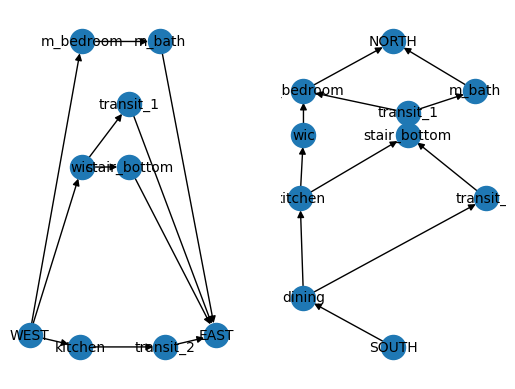

In [16]:
draw_cardinal_dags(Gxc, Gyc, domains)

In [20]:
# think about leveling sides..
# TODO update graph so that if something has no east or west nbs, it is connected to east and west.. 
w_nodes = [domains[e[1]] for e in Gxc.edges if "WEST" in e]
w_nodes

[Domain(m_bedroom, x=[0.06-3.14], y=[8.42-11.75]),
 Domain(wic, x=[0.06-1.93], y=[6.62-8.42]),
 Domain(kitchen, x=[0.00-3.34], y=[4.04-6.62])]

In [38]:
def normalize_to_target(arr):
    # log scale might be better.. 
    with localcontext() as ctx:
        ctx.prec = 3
        r_min, r_max = min(arr), max(arr)
        t_min, t_max = Decimal("0.1"), 1
        normalize = lambda x: (x-r_min)/(r_max - r_min)
        scale = lambda x: (normalize(x) * (t_max - t_min)) + t_min
        return [scale(i) for i in arr]

In [42]:
# find weighted average 



weights = normalize_to_target([i.area for i in w_nodes]) # this needs to be scaled between 0 and 1
print(weights)
vals  = [i.x.min for i in w_nodes]
val = mean([w*x for w,x in zip(weights,vals)])
val

[Decimal('1.0'), Decimal('0.100'), Decimal('0.786')]


Decimal('0.022')

In [47]:
a = 2
b = 3

tester = 9

side = "min" if tester == a  or  tester == b else "max"
print(side)

max


In [43]:
new_w_nodes = [i.x.update_side("min", val) for i in w_nodes]

In [44]:
new_w_nodes

[[0.022-3.14], [0.022-1.93], [0.022-3.34]]